In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
# fetch dataset 
solar_flare = fetch_ucirepo(id=89) 
  
# data (as pandas dataframes) 
X = solar_flare.data.features 
feature_names = X.columns.tolist()
# X = X.drop(columns=['modified Zurich class'])

# metadata 
print(solar_flare.metadata) 
  
# variable information 
print(solar_flare.variables) 


{'uci_id': 89, 'name': 'Solar Flare', 'repository_url': 'https://archive.ics.uci.edu/dataset/89/solar+flare', 'data_url': 'https://archive.ics.uci.edu/static/public/89/data.csv', 'abstract': 'Each class attribute counts the number of solar flares of a certain class that occur in a 24 hour period', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1389, 'num_features': 10, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['common flares', 'moderate flares', 'severe flares'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1989, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C5530G', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Notes:\r\n\r\n   -- The database contains 3 potential classes, one for the number of times a certain type of solar flare occured in a 24 hour period.\r\n   -- Each instance represents captur

In [2]:
import numpy as np
import torch

In [3]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders for both categorical columns
le_largest_spot = LabelEncoder()
le_spot_distribution = LabelEncoder()
le_modified_zurich_class = LabelEncoder()

# Fit and transform the categorical columns
X['largest spot size'] = le_largest_spot.fit_transform(X['largest spot size'])
X['spot distribution'] = le_spot_distribution.fit_transform(X['spot distribution'])
X['modified Zurich class'] = le_spot_distribution.fit_transform(X['modified Zurich class'])

c:\Users\swath\anaconda3\envs\pytorch\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\swath\anaconda3\envs\pytorch\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\swath\AppData\Local\Temp\ipykernel_18720\4147510705.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['largest spot size'] = le_largest_spot.fit_transform(X['largest spot size'])
c:\Users\swath\anaconda3\envs\

In [4]:


grouped_data = []

for _, group in X.groupby('largest spot size'):
    group_data = group.drop(columns=['largest spot size']).to_numpy()
    grouped_data.append(group_data)

In [5]:
datasets = grouped_data

In [6]:
feature_names.remove("largest spot size")

In [7]:
from src.ocsmm.OneClassSMMClassifier import OneClassSMMClassifier
classifier = OneClassSMMClassifier(nu=0.3)
classifier.fit(datasets)

In [8]:
decision, y_pred = classifier.predict(datasets)

In [9]:
decision


array([ 2.33775759,  0.33332432,  0.33335492,  0.33332451,  0.66058822,
       -1.00000695])

In [10]:
y_pred

array([ 1.,  1.,  1.,  1.,  1., -1.])

In [11]:
outlier_indices = [i for i, value in enumerate(y_pred) if value == -1]
outlier_indices

[5]

In [12]:
from src.explanation_algorithms.OCSMMSHAP import OCSMMSHAP
ocsmm_shap = OCSMMSHAP(X=datasets, classifier=classifier, decision=decision)
ocsmm_shap.fit_ocsmmshap(X=datasets, num_coalitions=2**len(feature_names))

c:\Users\swath\Documents\CISPA\OCSVM-SHAP\src\utils\shapley_procedure\coalitions.py:18: RuntimeWarning: divide by zero encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
c:\Users\swath\Documents\CISPA\OCSVM-SHAP\src\utils\shapley_procedure\coalitions.py:18: RuntimeWarning: invalid value encountered in cast
  set_to_1 = np.floor(np.log2(rest)).astype(int)
c:\Users\swath\Documents\CISPA\OCSVM-SHAP\src\utils\shapley_procedure\coalitions.py:18: RuntimeWarning: invalid value encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
100%|██████████| 511/511 [00:35<00:00, 14.38it/s]


In [13]:
mean_stochastic_shapley_values = ocsmm_shap.return_deterministic_shapley_values()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)


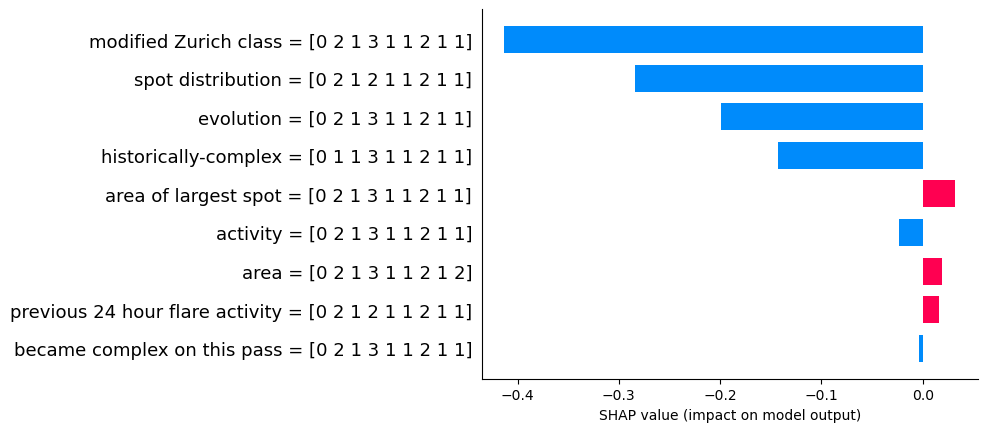

In [14]:
from src.utils.visualisation.deterministic_values import bar_plot
bar_plot(mean_stochastic_shapley_values.T[5], datasets[5], feature_names=feature_names)

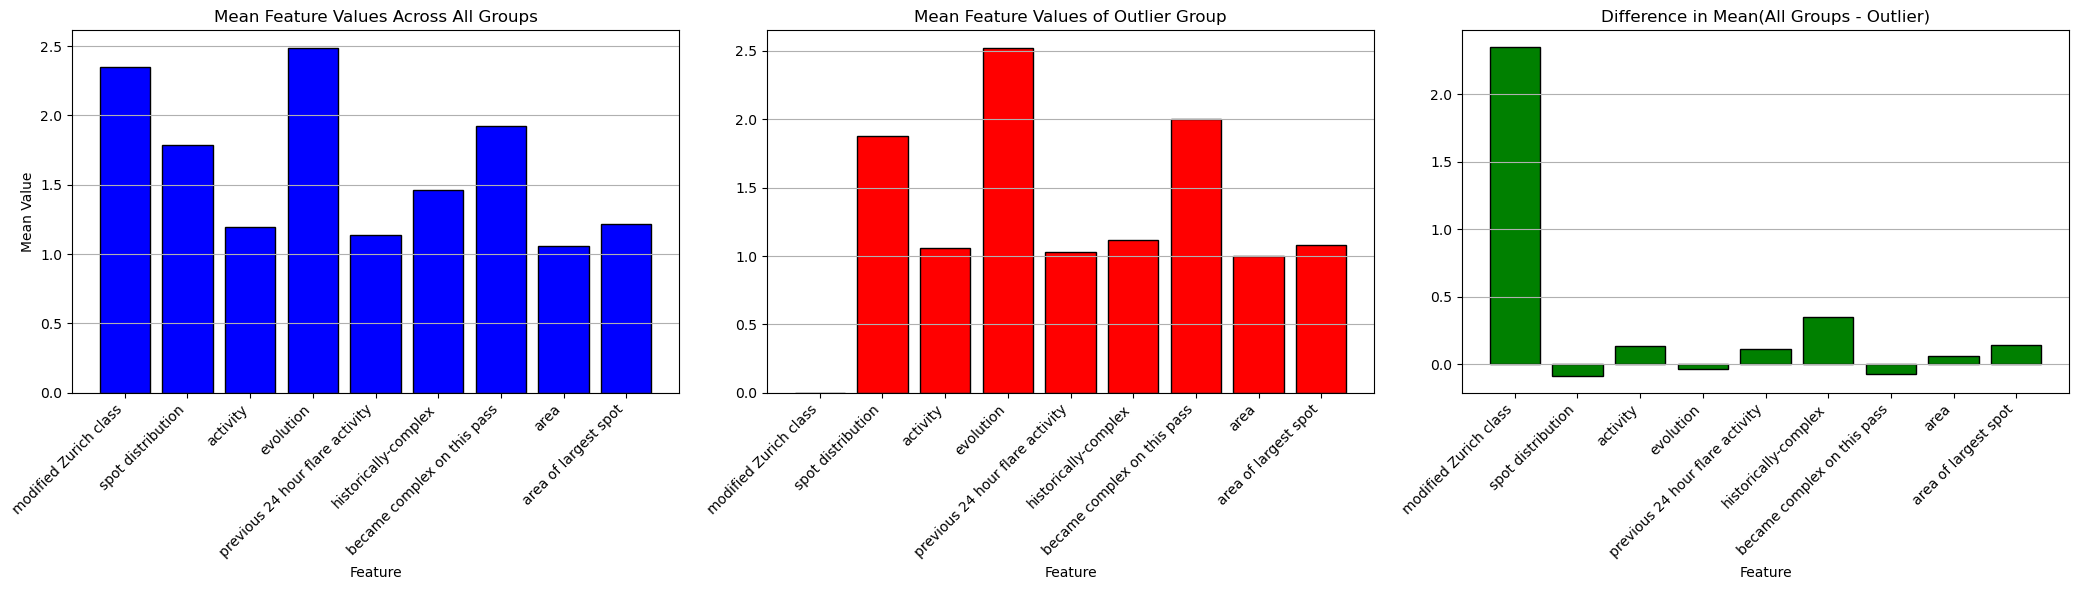

In [15]:
import matplotlib.pyplot as plt 
mean_all_groups = np.mean([np.mean(group, axis=0) for i, group in enumerate(datasets) if i != 8], axis=0)

# Compute mean feature values for the outlier group
mean_outlier_group = np.mean(datasets[5], axis=0)

# Compute the delta between the two (outlier vs all groups)
difference_values =  mean_all_groups - mean_outlier_group

percentage_change = ((mean_outlier_group - mean_all_groups) / mean_all_groups) * 100

# Feature names for labeling
num_features = len(mean_all_groups)
x_labels = feature_names[:num_features]  # Adjust based on the number of features

# Plot histograms
fig, ax = plt.subplots(1, 3, figsize=(21, 6), sharey=False)

# Mean feature values for all groups (excluding outlier)
ax[0].bar(range(num_features), mean_all_groups, color='blue', edgecolor='black')
ax[0].set_xticks(range(num_features))
ax[0].set_xticklabels(x_labels, rotation=45, ha='right')
ax[0].set_title('Mean Feature Values Across All Groups')
ax[0].set_xlabel('Feature')
ax[0].set_ylabel('Mean Value')
ax[0].grid(axis='y')

# Mean feature values for the outlier group
ax[1].bar(range(num_features), mean_outlier_group, color='red', edgecolor='black')
ax[1].set_xticks(range(num_features))
ax[1].set_xticklabels(x_labels, rotation=45, ha='right')
ax[1].set_title('Mean Feature Values of Outlier Group')
ax[1].set_xlabel('Feature')
ax[1].grid(axis='y')

# Delta values (difference between the outlier group and all groups)
ax[2].bar(range(num_features), difference_values, color='green', edgecolor='black')
ax[2].set_xticks(range(num_features))
ax[2].set_xticklabels(x_labels, rotation=45, ha='right')
ax[2].set_title('Difference in Mean(All Groups - Outlier)')
ax[2].set_xlabel('Feature')
ax[2].grid(axis='y')

# ax[3].bar(range(num_features), percentage_change, color='purple', edgecolor='black')
# ax[3].set_xticks(range(num_features))
# ax[3].set_xticklabels(x_labels, rotation=45, ha='right')
# ax[3].set_title('Percentage Change (Outlier - All Groups)')
# ax[3].set_xlabel('Feature')
# ax[3].grid(axis='y')

# fig, ax2 = plt.subplots(figsize=(14, 6))  # New figure for the percentage change plot
# ax2.bar(range(num_features), percentage_change, color='purple', edgecolor='black')
# ax2.set_xticks(range(num_features))
# ax2.set_xticklabels(x_labels, rotation=45, ha='right')
# ax2.set_title('Percentage Change (Outlier - All Groups)')
# ax2.set_xlabel('Feature')
# ax2.grid(axis='y')

plt.tight_layout()
plt.show()

In [16]:
X_scaled_df = pd.DataFrame(X, columns=X.columns)

grouped_data = []

for i, (_, group) in enumerate(X_scaled_df.groupby('largest spot size')):
    group_data = group.drop(columns=['largest spot size']).to_numpy()
    artificial_feature = np.ones((group_data.shape[0],1))  # Default value = 1
    if i == 0:  # and group has anomolous a_f
        artificial_feature.fill(20)
    
    group_data = np.hstack((group_data, artificial_feature))  # Append feature
    grouped_data.append(group_data)

In [17]:
feature_names.append('artificial_feature')

In [18]:
feature_names

['modified Zurich class',
 'spot distribution',
 'activity',
 'evolution',
 'previous 24 hour flare activity',
 'historically-complex',
 'became complex on this pass',
 'area',
 'area of largest spot',
 'artificial_feature']

In [19]:
datasets = grouped_data

In [20]:
datasets

[array([[ 2.,  2.,  1., ...,  1.,  2., 20.],
        [ 2.,  2.,  1., ...,  1.,  2., 20.],
        [ 2.,  2.,  1., ...,  1.,  1., 20.],
        ...,
        [ 3.,  1.,  1., ...,  1.,  1., 20.],
        [ 3.,  2.,  1., ...,  1.,  1., 20.],
        [ 3.,  1.,  2., ...,  1.,  1., 20.]]),
 array([[1., 1., 1., 3., 1., 1., 2., 1., 2., 1.],
        [5., 3., 1., 2., 1., 2., 2., 1., 1., 1.],
        [5., 3., 1., 3., 1., 1., 2., 1., 2., 1.],
        [2., 2., 1., 2., 1., 1., 2., 1., 2., 1.],
        [1., 1., 2., 3., 1., 1., 2., 1., 2., 1.],
        [1., 1., 2., 2., 3., 1., 2., 1., 2., 1.],
        [2., 1., 1., 3., 1., 1., 2., 1., 2., 1.],
        [2., 1., 2., 3., 3., 2., 2., 1., 2., 1.],
        [1., 1., 1., 2., 1., 2., 2., 1., 2., 1.],
        [1., 2., 1., 2., 1., 2., 2., 1., 2., 1.],
        [5., 3., 1., 3., 1., 1., 2., 1., 2., 1.],
        [5., 3., 1., 2., 1., 1., 1., 1., 1., 1.],
        [5., 3., 1., 3., 1., 1., 1., 1., 1., 1.],
        [1., 2., 1., 3., 1., 1., 2., 1., 1., 1.],
        [5., 3.

In [21]:
from src.ocsmm.OneClassSMMClassifier import OneClassSMMClassifier

In [22]:
classifier = OneClassSMMClassifier(nu=0.7)

In [23]:
classifier.fit(datasets)

In [24]:
decision, y_pred = classifier.predict(datasets)

In [25]:
y_pred

array([-1.,  1.,  1.,  1.,  1., -1.])

In [26]:
decision

array([-0.1235487 ,  0.46689342,  0.37314437,  0.16346445,  0.37314312,
       -0.7862045 ])

In [27]:
outlier_indices = [i for i, value in enumerate(y_pred) if value == -1]
outlier_indices

[0, 5]

In [28]:
from src.explanation_algorithms.OCSMMSHAP import OCSMMSHAP
ocsmm_shap = OCSMMSHAP(X=datasets, classifier=classifier, decision=decision)
ocsmm_shap.fit_ocsmmshap(X=datasets, num_coalitions=2**len(feature_names))

divide by zero encountered in log2
invalid value encountered in cast
invalid value encountered in log2
100%|██████████| 1023/1023 [00:30<00:00, 34.01it/s]


In [29]:
mean_stochastic_shapley_values = ocsmm_shap.return_deterministic_shapley_values()

In [30]:
mean_stochastic_shapley_values

tensor([[-2.9409e-02,  1.1123e-01,  3.1676e-02,  1.4554e-01,  5.0352e-02,
         -2.7109e-01],
        [-4.4254e-02,  4.5123e-02,  4.9173e-02,  6.3931e-02,  1.2200e-01,
         -1.7990e-01],
        [ 6.7239e-03,  2.5094e-02,  5.2972e-02, -1.1695e-02, -6.7839e-05,
         -2.7269e-02],
        [ 1.9242e-02,  4.5123e-02,  1.9475e-02,  4.8806e-03,  6.0363e-02,
         -1.0773e-01],
        [-3.8516e-03,  2.7512e-02,  5.5389e-02, -1.3508e-02,  2.8674e-03,
         -2.1744e-02],
        [ 2.8047e-02,  6.8260e-02,  4.7101e-02, -1.4026e-02, -5.0750e-03,
         -6.9398e-02],
        [-1.4643e-02,  2.9756e-02, -2.0927e-02, -7.2057e-03,  1.1527e-01,
         -5.7312e-02],
        [ 3.7455e-03,  1.3699e-02,  4.2612e-02, -4.8748e-03,  3.0401e-03,
         -1.3111e-02],
        [-2.8886e-02,  6.3249e-02,  7.3687e-02, -1.6097e-02,  4.0758e-03,
         -4.7986e-02],
        [-6.0265e-02,  3.7869e-02,  2.2064e-02,  1.6189e-02,  2.0478e-02,
          9.6801e-03]])

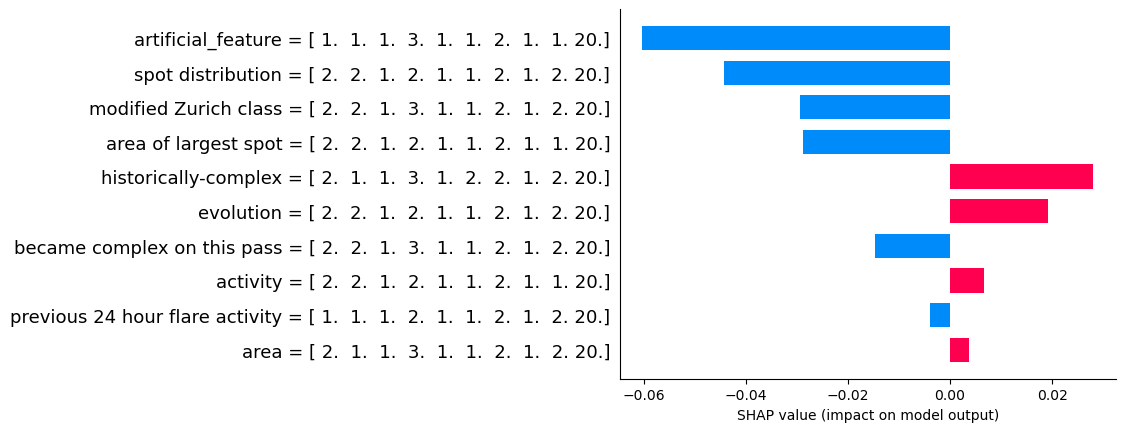

In [31]:
from src.utils.visualisation.deterministic_values import summary_plot, bar_plot
bar_plot(mean_stochastic_shapley_values.T[0], datasets[0], feature_names=feature_names)

artificial feature is the highest contribution towars making this group an outlier.

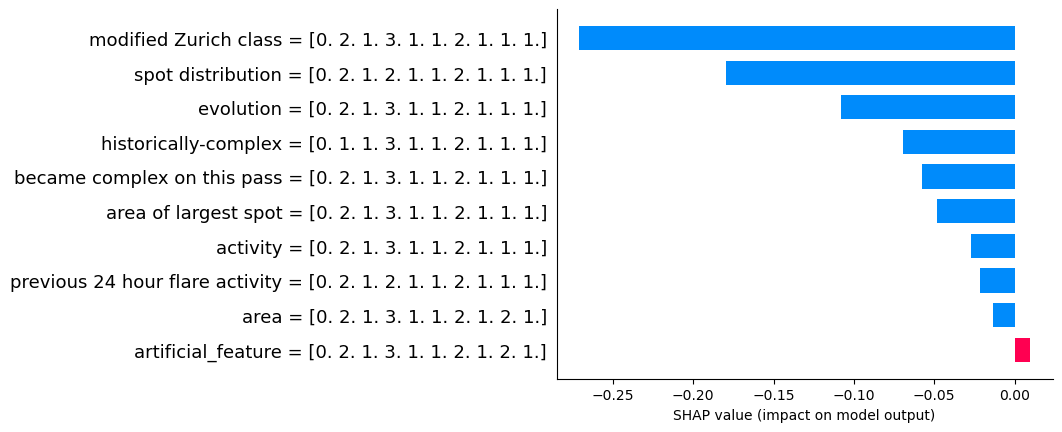

In [32]:
bar_plot(mean_stochastic_shapley_values.T[5], datasets[5], feature_names=feature_names)

For the other outlier, it is caused due to other reasons(similar to first part) and not artificial_feature.